In [137]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb
import scipy
import time
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb

In [138]:
import tensorflow as tf

In [139]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [140]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')

In [141]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
dataset_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

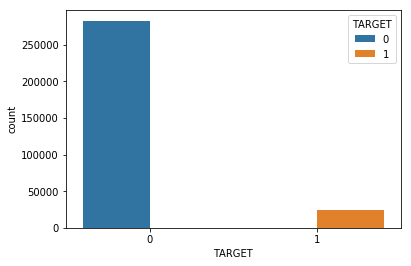

In [143]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train)

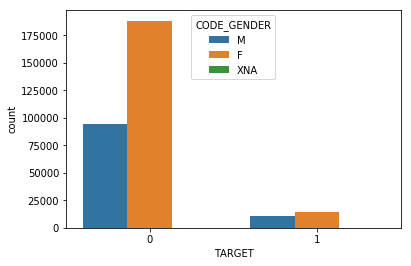

In [84]:
sb.countplot(x='TARGET',hue='CODE_GENDER',data=dataset_train)

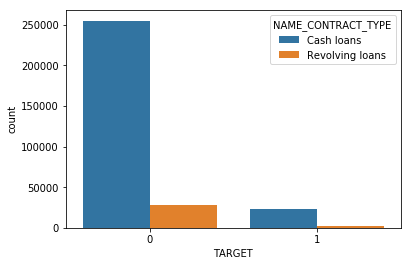

In [145]:
sb.countplot(x='TARGET',hue='NAME_CONTRACT_TYPE',data=dataset_train)

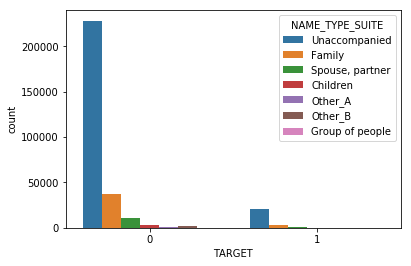

In [146]:
sb.countplot(x='TARGET',hue='NAME_TYPE_SUITE',data=dataset_train)

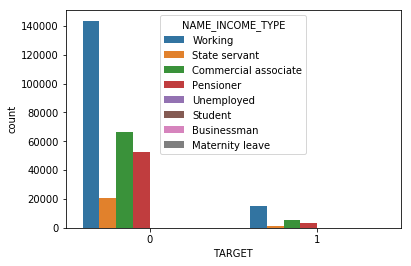

In [147]:
sb.countplot(x='TARGET',hue='NAME_INCOME_TYPE',data=dataset_train)

In [148]:
(dataset_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

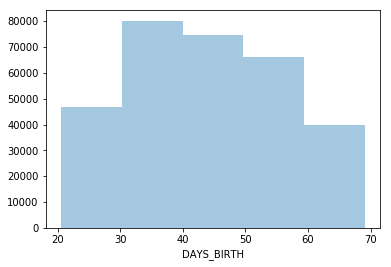

In [149]:
sb.distplot(dataset_train['DAYS_BIRTH']/-365,bins=5,kde=False)

In [150]:
len(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0])


55374

In [151]:
(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0]['TARGET'] == 1).value_counts()

False    52384
True      2990
Name: TARGET, dtype: int64

In [152]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    307511.000000
mean        185.547239
std         382.037676
min           0.000000
25%           2.556164
50%           6.079452
75%          15.635616
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

In [153]:
max(dataset_train['DAYS_EMPLOYED'])

365243

In [154]:
len(dataset_train['DAYS_EMPLOYED'] == 365243)

307511

In [155]:
dataset_train['EMP_AN'] = dataset_train['DAYS_EMPLOYED'] == 365243

In [156]:
dataset_train['DAYS_EMPLOYED'] = dataset_train['DAYS_EMPLOYED'].replace({365243: np.nan})

In [157]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    252137.000000
mean          6.531971
std           6.406466
min           0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [158]:
(abs(dataset_train['DAYS_REGISTRATION']/365)).describe()

count    307511.000000
mean         13.660604
std           9.651743
min           0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

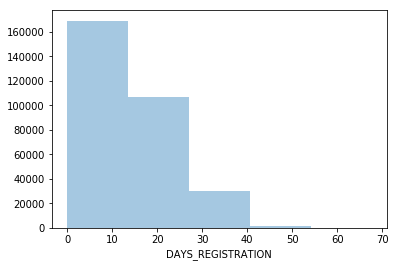

In [159]:
sb.distplot(dataset_train['DAYS_REGISTRATION']/-365,bins=5,kde=False)

In [160]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

80

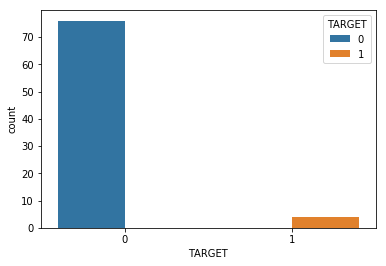

In [161]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50])

In [162]:
dataset_train = dataset_train.drop(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50].index,axis=0)

In [163]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

0

In [164]:
dataset_train.shape

(307431, 123)

In [166]:
corr = dataset_train.corr(method='pearson')

In [167]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

CNT_CHILDREN - CNT_FAM_MEMBERS
0.8791849055884082
AMT_CREDIT - AMT_ANNUITY
0.7701355325112837
REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.9508244177203856
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.8606542659268078
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8255558750839367
APARTMENTS_AVG - ELEVATORS_AVG
0.8369526900299763
BASEMENTAREA_AVG - BASEMENTAREA_MODE
0.973496185301789
YEARS_BEGINEXPLUATATION_AVG - YEARS_BEGINEXPLUATATION_MODE
0.97189305389083
YEARS_BUILD_AVG - YEARS_BUILD_MODE
0.9894360514168624
COMMONAREA_AVG - COMMONAREA_MODE
0.9771461116759385
ENTRANCES_AVG - ENTRANCES_MODE
0.9777417653401914
FLOORSMAX_AVG - FLOORSMIN_AVG
0.7424268126795673
LANDAREA_AVG - LANDAREA_MODE
0.9736925929909296
LIVINGAPARTMENTS_AVG - LIVINGAREA_AVG
0.8807913124080583
NONLIVINGAPARTMENTS_AVG - NONLIVINGAPARTMENTS_MODE
0.9693697425066614
NONLIVINGAREA_AVG - NONLIVINGAREA_MODE
0.9660854607189583
APARTMENTS_MODE - ELEVATORS_MODE
0.8262109330460732
FLOORSMAX_MODE - FLOO

In [168]:
#Columnd to remove die to high correlation (Only measured colinearity among pairs of parameters still have to deal
#with multi-colinearity)
columns_to_remove = ['CNT_CHILDREN','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_WORK_REGION',
                    'LIVE_CITY_NOT_WORK_CITY','ELEVATORS_AVG','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BUILD_MODE','COMMONAREA_MODE','ENTRANCES_MODE','FLOORSMIN_AVG','LANDAREA_MODE',
                    'LIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE','ELEVATORS_MODE','FLOORSMIN_MODE',
                    'LIVINGAREA_MODE','ELEVATORS_MEDI','FLOORSMIN_MEDI','LIVINGAREA_MEDI','OBS_60_CNT_SOCIAL_CIRCLE',
                    'DEF_60_CNT_SOCIAL_CIRCLE']

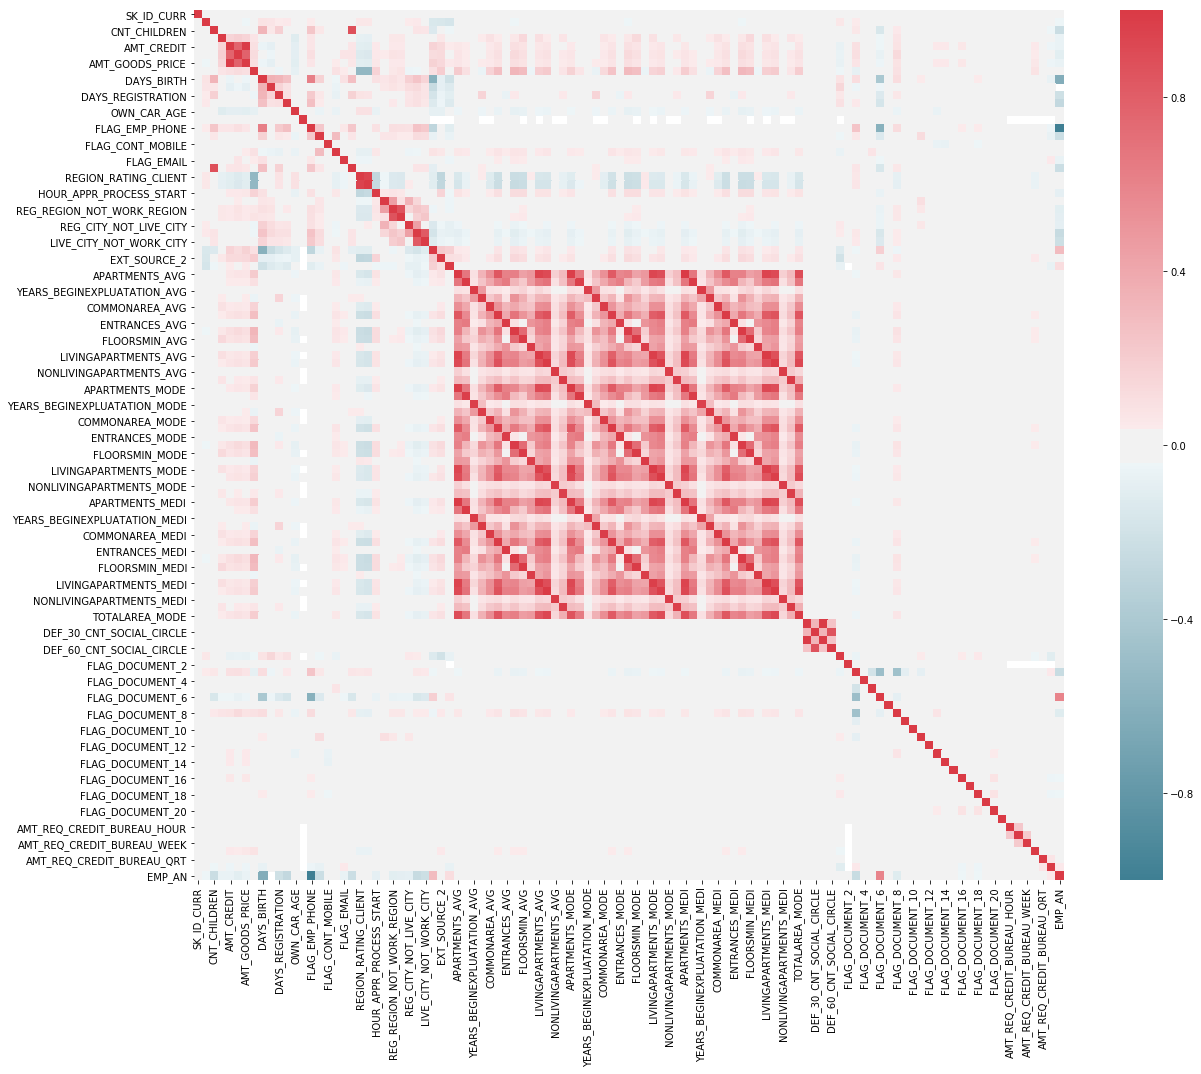

In [169]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [170]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

In [171]:
dataset_train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [172]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']
starttime = time.time()
for column in columns_to_label_encode:
    le = LabelEncoder()
    dataset_train[column] = le.fit_transform(dataset_train[column].astype(str))
endtime = time.time()
print("Time Elapsed:- ")
print(endtime - starttime)

Time Elapsed:- 
0.3121531009674072


In [173]:
columns_to_one_hot_encode = ['CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                             'OCCUPATION_TYPE','ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                            'FONDKAPREMONT_MODE','WALLSMATERIAL_MODE','HOUSETYPE_MODE']
starttime = time.time()
for column in columns_to_one_hot_encode:
    le = LabelEncoder()
    oe = OneHotEncoder()
    label_encoded = le.fit_transform(dataset_train[column].astype(str))
    label_encoded = label_encoded.reshape(-1,1)
    one_hot_encoded = oe.fit_transform(label_encoded).toarray()
    df = pd.DataFrame(one_hot_encoded,columns=[column + str(i) for i in range(0,one_hot_encoded.shape[1])])
    df = df.drop([column + "0"],axis=1)
    dataset_train = pd.concat([dataset_train,df],axis=1)
    print(column + " - " + str(dataset_train.shape[0]) + " " + str(dataset_train.shape[1]))
dataset_train = dataset_train.drop(columns_to_one_hot_encode,axis=1)
dataset_train.shape

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


CODE_GENDER - 307511 103


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_TYPE_SUITE - 307511 110


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_INCOME_TYPE - 307511 118


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_EDUCATION_TYPE - 307511 123


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_FAMILY_STATUS - 307511 129


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_HOUSING_TYPE - 307511 135


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OCCUPATION_TYPE - 307511 153


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ORGANIZATION_TYPE - 307511 211


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


WEEKDAY_APPR_PROCESS_START - 307511 218


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


FONDKAPREMONT_MODE - 307511 222


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


WALLSMATERIAL_MODE - 307511 229


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


HOUSETYPE_MODE - 307511 232


(307511, 220)

In [174]:
dataset_train['DIR'] = dataset_train['AMT_CREDIT']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['AIR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['ACR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_CREDIT']
dataset_train['DAR'] = dataset_train['DAYS_EMPLOYED']/dataset_train['DAYS_BIRTH']

In [175]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(40000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [176]:
from sklearn.preprocessing import StandardScaler, Imputer
imputer = Imputer(strategy='median')
scaler = StandardScaler()
dataset_train_tr = imputer.fit_transform(dataset_train.drop(['SK_ID_CURR','TARGET'],axis=1))
dataset_train_tr = scaler.fit_transform(dataset_train_tr)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [177]:
X = dataset_train_tr
y = dataset_train['TARGET']

In [178]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [179]:
X_test = pd.DataFrame(X_test,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))

In [180]:
X_test.shape

(12000, 222)

In [181]:
y_test.shape

(12000,)

In [182]:
#Using SMOTE(Synthetic Minority Oversampling Technique) to handle imbalanced dataset
smote_train = SMOTE(random_state=232)
os_data_X,os_data_y = smote_train.fit_sample(X_train,y_train)
X_train = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']) )
y_train = pd.DataFrame(data=os_data_y,columns=["TARGET"])

In [183]:
X_test.shape

(12000, 222)

In [185]:
y_test.shape

(12000,)

In [186]:
smote_test = SMOTE(random_state=232)
os_data_X,os_data_Y = smote_test.fit_sample(X_test,y_test)
X_test = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))
y_test = pd.DataFrame(data=os_data_Y,columns=['TARGET'])

In [187]:
X_train.shape

(63824, 222)

In [188]:
y_train.shape

(63824, 1)

In [189]:
X_test.shape

(16176, 222)

In [190]:
y_test.shape

(16176, 1)

In [46]:
def generate_classifier_report(classifier,predictions,predictions_prob,name):
    print(classification_report(y_test,predictions))
    logit_roc_score = roc_auc_score(y_test,predictions)
    f
    pr, tpr, thresholds = roc_curve(y_test,predictions_prob)
    plt.figure()
    plt.plot(fpr,tpr,label=name + " AUC score:- " + str(logit_roc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate (FP / (FP + TN))')
    plt.ylabel('True Positive Rate (TP / (TP + FN))')
    plt.title('Receiver Operating Characteristics Curve')
    plt.legend(loc="lower right")
    plt.savefig(name + "_roc_curve")
    plt.show()

In [191]:
X.shape

(60000, 222)

In [192]:
y.shape

(60000,)

In [193]:
y_train = np.array(y_train)
y_train = y_train.ravel()

In [194]:
y_test = np.array(y_test)
y_test = y_test.ravel()

In [51]:
#Use k-fold cross validation to generate estimate of test accuracy

In [195]:
clf = LogisticRegression(C=0.4,max_iter = 1000)
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [196]:
prediction = clf.predict(X_test)

In [197]:
accuracy_score(y_test,prediction)

0.6948565776458951

In [198]:
confusion_matrix(y_test,prediction)

array([[5637, 2451],
       [2485, 5603]])

              precision    recall  f1-score   support

         0.0       0.69      0.70      0.70      8088
         1.0       0.70      0.69      0.69      8088

   micro avg       0.69      0.69      0.69     16176
   macro avg       0.69      0.69      0.69     16176
weighted avg       0.69      0.69      0.69     16176



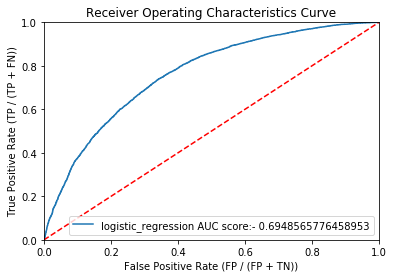

In [199]:
generate_classifier_report(clf,prediction,clf.predict_proba(X_test)[:,1],name="logistic_regression")

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Time to train 10 trees:- 
1.983670949935913
Accuracy score for 10 trees:- 
0.6866666666666666
Confusion matrix for 10 trees:- 
[6544 1544 2216 1696]
Classifier report for 10 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78      8088
         1.0       0.52      0.43      0.47      3912

   micro avg       0.69      0.69      0.69     12000
   macro avg       0.64      0.62      0.63     12000
weighted avg       0.67      0.69      0.68     12000



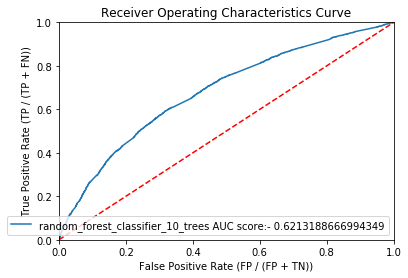

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Time to train 20 trees:- 
4.386920928955078
Accuracy score for 20 trees:- 
0.6998333333333333
Confusion matrix for 20 trees:- 
[6638 1450 2152 1760]
Classifier report for 20 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79      8088
         1.0       0.55      0.45      0.49      3912

   micro avg       0.70      0.70      0.70     12000
   macro avg       0.65      0.64      0.64     12000
weighted avg       0.69      0.70      0.69     12000



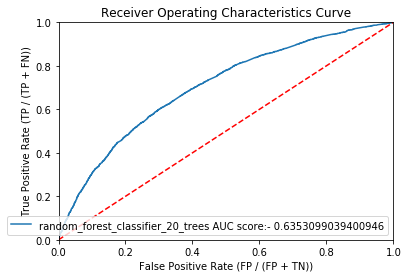

Time to train 30 trees:- 
6.830815076828003
Accuracy score for 30 trees:- 
0.7015
Confusion matrix for 30 trees:- 
[6716 1372 2210 1702]
Classifier report for 30 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.83      0.79      8088
         1.0       0.55      0.44      0.49      3912

   micro avg       0.70      0.70      0.70     12000
   macro avg       0.65      0.63      0.64     12000
weighted avg       0.69      0.70      0.69     12000



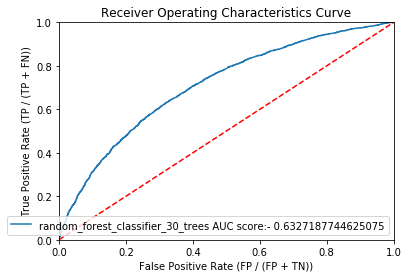

Time to train 40 trees:- 
8.900564193725586
Accuracy score for 40 trees:- 
0.7053333333333334
Confusion matrix for 40 trees:- 
[6756 1332 2204 1708]
Classifier report for 40 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79      8088
         1.0       0.56      0.44      0.49      3912

   micro avg       0.71      0.71      0.71     12000
   macro avg       0.66      0.64      0.64     12000
weighted avg       0.69      0.71      0.69     12000



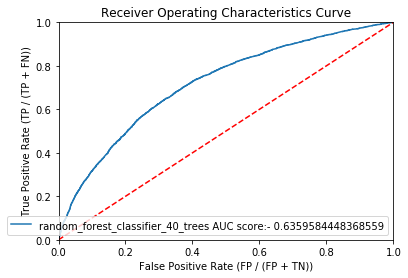

Time to train 50 trees:- 
14.717772960662842
Accuracy score for 50 trees:- 
0.7126666666666667
Confusion matrix for 50 trees:- 
[6852 1236 2212 1700]
Classifier report for 50 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80      8088
         1.0       0.58      0.43      0.50      3912

   micro avg       0.71      0.71      0.71     12000
   macro avg       0.67      0.64      0.65     12000
weighted avg       0.70      0.71      0.70     12000



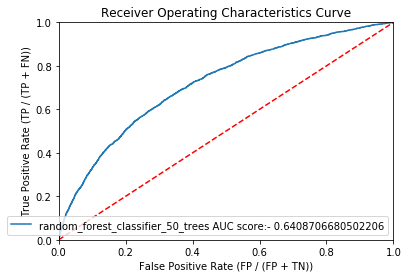

Time to train 100 trees:- 
23.703979015350342
Accuracy score for 100 trees:- 
0.717
Confusion matrix for 100 trees:- 
[6878 1210 2186 1726]
Classifier report for 100 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80      8088
         1.0       0.59      0.44      0.50      3912

   micro avg       0.72      0.72      0.72     12000
   macro avg       0.67      0.65      0.65     12000
weighted avg       0.70      0.72      0.70     12000



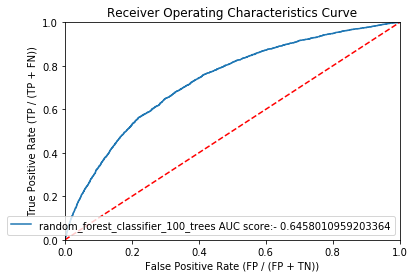

Time to train 150 trees:- 
38.08758997917175
Accuracy score for 150 trees:- 
0.715
Confusion matrix for 150 trees:- 
[6883 1205 2215 1697]
Classifier report for 150 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80      8088
         1.0       0.58      0.43      0.50      3912

   micro avg       0.71      0.71      0.71     12000
   macro avg       0.67      0.64      0.65     12000
weighted avg       0.70      0.71      0.70     12000



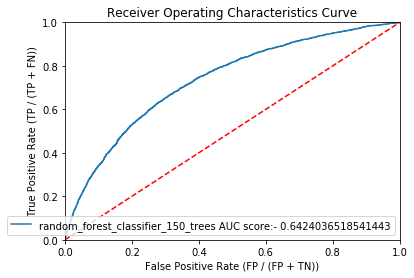

Time to train 200 trees:- 
43.93514800071716
Accuracy score for 200 trees:- 
0.7168333333333333
Confusion matrix for 200 trees:- 
[6926 1162 2236 1676]
Classifier report for 200 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.80      8088
         1.0       0.59      0.43      0.50      3912

   micro avg       0.72      0.72      0.72     12000
   macro avg       0.67      0.64      0.65     12000
weighted avg       0.70      0.72      0.70     12000



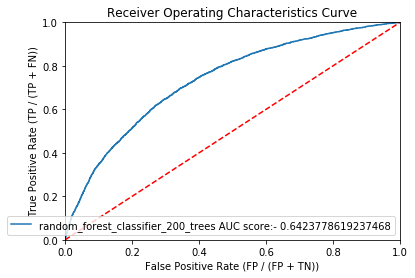

Time to train 250 trees:- 
53.97599220275879
Accuracy score for 250 trees:- 
0.7213333333333334
Confusion matrix for 250 trees:- 
[6950 1138 2206 1706]
Classifier report for 250 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      8088
         1.0       0.60      0.44      0.51      3912

   micro avg       0.72      0.72      0.72     12000
   macro avg       0.68      0.65      0.66     12000
weighted avg       0.71      0.72      0.71     12000



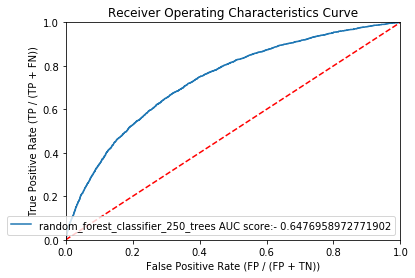

Time to train 300 trees:- 
60.30361008644104
Accuracy score for 300 trees:- 
0.7189166666666666
Confusion matrix for 300 trees:- 
[6928 1160 2213 1699]
Classifier report for 300 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.80      8088
         1.0       0.59      0.43      0.50      3912

   micro avg       0.72      0.72      0.72     12000
   macro avg       0.68      0.65      0.65     12000
weighted avg       0.70      0.72      0.71     12000



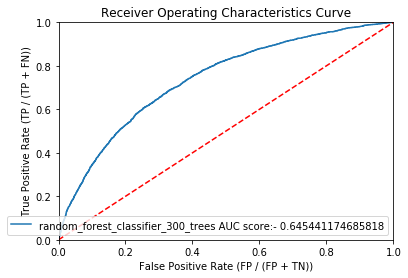

Time to train 400 trees:- 
88.9971399307251
Accuracy score for 400 trees:- 
0.7164166666666667
Confusion matrix for 400 trees:- 
[6922 1166 2237 1675]
Classifier report for 400 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.80      8088
         1.0       0.59      0.43      0.50      3912

   micro avg       0.72      0.72      0.72     12000
   macro avg       0.67      0.64      0.65     12000
weighted avg       0.70      0.72      0.70     12000



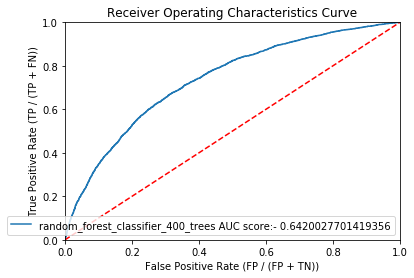

Time to train 500 trees:- 
124.32945513725281
Accuracy score for 500 trees:- 
0.7213333333333334
Confusion matrix for 500 trees:- 
[6949 1139 2205 1707]
Classifier report for 500 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      8088
         1.0       0.60      0.44      0.51      3912

   micro avg       0.72      0.72      0.72     12000
   macro avg       0.68      0.65      0.66     12000
weighted avg       0.71      0.72      0.71     12000



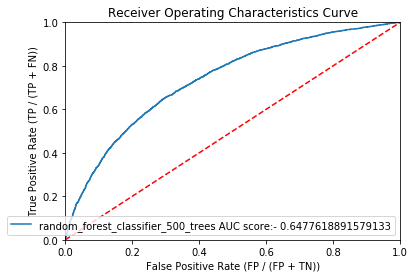

Time to train 750 trees:- 
155.13248991966248
Accuracy score for 750 trees:- 
0.7200833333333333
Confusion matrix for 750 trees:- 
[6952 1136 2223 1689]
Classifier report for 750 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      8088
         1.0       0.60      0.43      0.50      3912

   micro avg       0.72      0.72      0.72     12000
   macro avg       0.68      0.65      0.65     12000
weighted avg       0.71      0.72      0.71     12000



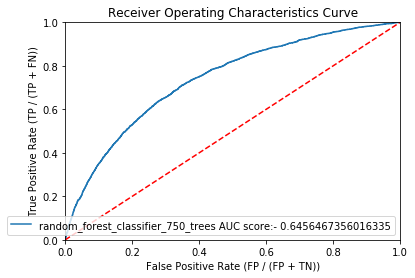

Time to train 1000 trees:- 
246.86997509002686
Accuracy score for 1000 trees:- 
0.72025
Confusion matrix for 1000 trees:- 
[6945 1143 2214 1698]
Classifier report for 1000 trees:- 
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      8088
         1.0       0.60      0.43      0.50      3912

   micro avg       0.72      0.72      0.72     12000
   macro avg       0.68      0.65      0.65     12000
weighted avg       0.71      0.72      0.71     12000



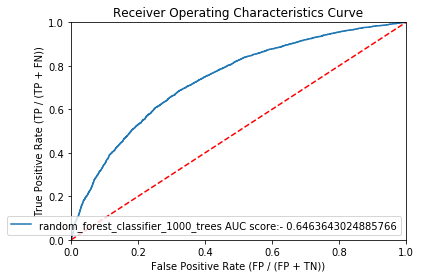

In [127]:
#Have to use Bayesian Optimization to find better set of hyperparameters
#performant value found 400
no_of_trees = [10,20,30,40,50,100,150,200,250,300,400,500,750,1000]
error = []
for noft in no_of_trees:
    starttime = time.time()
    classifier = RandomForestClassifier(n_estimators=noft,max_depth=25,oob_score=True)
    classifier.fit(X_train,y_train)
    endtime = time.time()
    print("Time to train " + str(noft) + " trees:- ")
    print(endtime - starttime)
    error.append(classifier.oob_score_)
    prediction = classifier.predict(X_test)
    print("Accuracy score for " + str(noft) + " trees:- ")
    print(accuracy_score(y_test,prediction))
    print("Confusion matrix for " + str(noft) + " trees:- ")
    print(confusion_matrix(y_test,prediction).ravel())
    print("Classifier report for " + str(noft) + " trees:- ")
    generate_classifier_report(classifier,prediction,classifier.predict_proba(X_test)[:,1],"random_forest_classifier_" + str(noft) + "_trees")

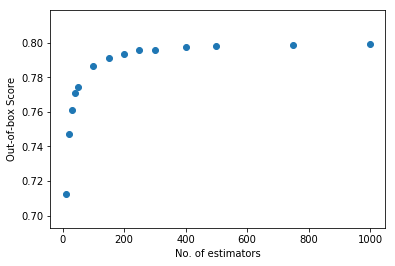

In [128]:
plt.scatter(no_of_trees,error)
plt.xlabel("No. of estimators")
plt.ylabel("Out-of-box Score")
plt.savefig("error_vs_nestimators.jpg")

In [59]:
starttime = time.time()
boosting = XGBClassifier(alpha=1,eval_metric='logloss',max_depth=25,n_estimators=400,verbosity=2)
boosting.fit(X_train,y_train)
endtime = time.time()
print("Time to train XGBClassifier :- ")
print(endtime - starttime)

Time to train XGBClassifier :- 
929.0983400344849


In [60]:
pred = boosting.predict(X_test)
accuracy_score(y_test,pred)

0.7315833333333334

In [61]:
confusion_matrix(y_test,pred)

array([[6943, 1145],
       [2076, 1836]])

              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81      8088
         1.0       0.62      0.47      0.53      3912

   micro avg       0.73      0.73      0.73     12000
   macro avg       0.69      0.66      0.67     12000
weighted avg       0.72      0.73      0.72     12000



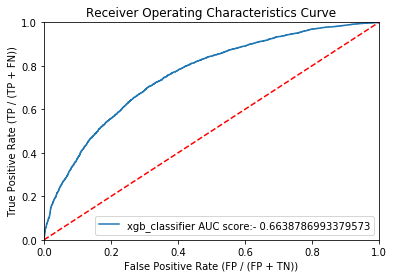

In [62]:
generate_classifier_report(boosting,pred,boosting.predict_proba(X_test)[:,1],'xgb_classifier')

In [64]:
starttime = time.time()
clf = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=400,max_depth=25)
clf.fit(X_train,y_train)
endtime = time.time()
print("Time to train LightGBM classifier:- ")
print(endtime - starttime)

Time to train LightGBM classifier:- 
30.337963819503784


In [65]:
pref = clf.predict(X_test)
accuracy_score(y_test,pred)

0.7315833333333334

In [66]:
confusion_matrix(y_test,pred)

array([[6943, 1145],
       [2076, 1836]])

              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81      8088
         1.0       0.62      0.47      0.53      3912

   micro avg       0.73      0.73      0.73     12000
   macro avg       0.69      0.66      0.67     12000
weighted avg       0.72      0.73      0.72     12000



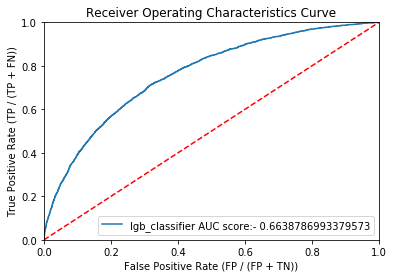

In [67]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],'lgb_classifier')

In [68]:
X = tf.placeholder(shape=[None,222],dtype=tf.float32)
y = tf.placeholder(shape=[None],dtype=tf.int64)

In [69]:
weights = {
    'W1': tf.Variable(tf.truncated_normal(shape=[222,140])),
    'W2': tf.Variable(tf.truncated_normal(shape=[140,70])),
    'W3': tf.Variable(tf.truncated_normal(shape=[70,27])),
    'W4': tf.Variable(tf.truncated_normal(shape=[27,1]))
}
biases = {
    'b1': tf.Variable(tf.truncated_normal(shape=[140])),
    'b2': tf.Variable(tf.truncated_normal(shape=[70])),
    'b3': tf.Variable(tf.truncated_normal(shape=[27])),
    'b4': tf.Variable(tf.truncated_normal(shape=[1]))
}

In [70]:
def get_model(X,weights,biases):
    op1 = tf.add(tf.matmul(X,weights['W1']),biases['b1'])
    relu_op1 = tf.nn.relu(op1) 
    op2 = tf.add(tf.matmul(relu_op1,weights['W2']),biases['b2'])
    relu_op2 = tf.nn.relu(op2)
    op3 = tf.add(tf.matmul(relu_op2,weights['W3']),biases['b3'])
    relu_op3 = tf.nn.relu(op3)
    op4 = tf.add(tf.matmul(relu_op3,weights['W4']),biases['b4'])
    return op4

In [71]:
pred = get_model(X,weights,biases)
optimizer = tf.train.AdamOptimizer(learning_rate=0.)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))
train_step = optimizer.minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [72]:
#Improve accuracy here 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(0,10):
        cost = 0
        total_batch = X_train.shape[0]/100
        X_batches = np.array_split(X_train,total_batch)
        y_batches = np.array_split(y_train,total_batch)
        for j in range(0,int(total_batch)):
            g,c = sess.run([train_step,loss],feed_dict={
                X: X_batches[j],
                y: y_batches[j]
            })
            cost = cost + c/total_batch
        print("Epoch:- " + str(i) + " Cost:- " + str(cost))
    correct_prediction = tf.equal(tf.argmax(pred,1),y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
    print("Accuracy:- " + str(accuracy.eval({X: X_test,y: y_test})))

Epoch:- 0 Cost:- 230.27163413749093
Epoch:- 1 Cost:- 230.27163413749093
Epoch:- 2 Cost:- 230.27163413749093
Epoch:- 3 Cost:- 230.27163413749093
Epoch:- 4 Cost:- 230.27163413749093
Epoch:- 5 Cost:- 230.27163413749093
Epoch:- 6 Cost:- 230.27163413749093
Epoch:- 7 Cost:- 230.27163413749093
Epoch:- 8 Cost:- 230.27163413749093
Epoch:- 9 Cost:- 230.27163413749093
Accuracy:- 0.674


In [73]:
starttime = time.time()
clf = SVC(gamma=0.001, C=1.0)
clf.fit(X_train,y_train)
endtime = time.time()
print("Time to train SVC classifier:- ")
print(endtime - starttime)

Time to train SVC classifier:- 
1281.0041320323944


In [74]:
pred = clf.predict(X_test)
accuracy_score(y_test,pred)

0.6945

In [75]:
confusion_matrix(y_test,pred).ravel()

array([5746, 2342, 1324, 2588])